# Sensors Data EDA & User Behavior Prediction

Aug 2018, 
Lexie Nie

# <font color='green'>Executive Summary</font> 
### <font color='green'>1. Data Loading & Cleaning Dirty Log data: </font> 
1. The original data is raw log file. When reading the data in, we pre-processed and cleaned the log by excluding the duplicated "lib":{} info, and the unnecessary "properties":{ } text, and read in line by line to get the list of 75091 entries. 
2. We split the entries by ',', and ':', with some text cleaning, getting the data into a data-frame format (75091, 66), with each event level entries in a row.


### <font color='green'> 2. First Round Event-level Feature Pre-processing & EDA: </font> 
1. Columns are all imported as String, convert numerical features back to float, and treat Unix timestamp
2. Look at User Activity distribution along date. As expected, weekend has lower activity level. 31st seems isolated, which later we found the reason and excluded the outlier. 
3. Convert ip address to location information, and look at User Activity distribution for different geo zone. 'Beijing','Shanghai'and 'Guangzhou'  seem to be hot zone as expected. 
4. Look at Funnel analysis by event, where the user activity drops sharply seem to be: from PageView to ButtonClick 
5. Check utm performance:
different versions of information available about referrer and utm: first/last, url, host, source, medium, campaign, content, term. They're correlated but not fully exchangeable. Found the ones with the most information and collapsed to fewer levels.
6. Look at other features distribution pattern and correlations, as well as missing value conditions. Determine if and how to use these event-level features to transform into user level features.

#### Observations: 
1. 2017-03-31 and 'type' feature: type=profile_set_once has 9419 records all happened on 2017-03-31  between 11:04 and 11:06: with most of the column values NA. That's also all the entries for 2017-03-31, which is further away from our date range. It seems like to be a one time system setting or error. Let's exclude those records for further analysis. 
2. Some features have the same values for all entries, no need to put into the model: ex. lib, lib_version
3. Some features are total different for each entry/user, but not providing useful information modeling that need to be excluded later: distinct_id, _nocache
4. Some features only happen with specific events, ex: 
<br>
--> isMsg & isSuccess comes along with formSubmit
<br>
--> requestBtn only happens for click and submit event
<br>
--> pageStayTime: only available for the _leave, or _close pages, not the instance pages (view, click, submit, code),might need capping and log transformation later.
<br>
--> pagePosition: only available for '_leave' events, and only have value other then 1 for 'index_leave' event.


### <font color='green'> 3. Data Transformation to User-level Feature Generation: </font> 

1. User profile and referrer, utm related features:
<br>
It's almost a 1 to 1 ratio. the distinct_id with multiple os, model, ip could be potential heavy users, so we cannot disregard. Here we select the most frequent value for their user profile feature, and created a new feature called 'multi_device_flag'.

2. Event-base features:
<br>
2.1 Collapse features to meaningful bigger buckets before generating dummy variables: 
<br>
2.2 Generate Dummy features for all categorical features: in a form of if this value exist (1), or not (0).
<br>
2.3 Sum the boolean features created as count of the action happening:

3. Page specific features: 
<br>
These feature only occurs with specific pages/events, ex.:
<br>
pageStayTime only exist for '_leave' events
<br>
value of PagePosition only varies when event=index_leave
<br>
So cannot simply aggregate them at a user level. Hence created specific features for the specific events with an average for these feature values.

4. Time related features:
<br>
Created several features related to timestamp: 
<br>
a. Total time span for this user: time difference between their last activity to their first activity. 
<br>
b.Day of Week
<br>
c.Hour of Day 


### <font color='green'> 4. Second Round User-level Feature Pre-processing & EDA: </font> 

1. Define Response Variable Y as formSubmit: 
Based on the first round of EDA, formSubmit seems to be a reasonable classification target, since it has a bigger 'yes' population. Also, it reflects purely on user intension, not impacted by system errors, cell phone outage, etc. So it's better for predictive modeling.
2. Because of the nature of the data, the EDA & feature pre-processing has been done in the sequence of user profile features -> referrer & utm features -> event/page level features -> time features. 

3. For categorical features: Collapse levels when necessary: look at top frequency levels, and levels with interesting user behaviors.
4. For numerical features: check nonlinearity through binning and plotting subscription rate across different bins, checking if any treatment is necessary. See if capping and log transformation is needed. 
5. Since we're using tree based models later, although certain transformation will help Logistic Regression, it also loss information or granularity and would hurt the classification effort. Hence during these steps, we tried to keep the features as original as possible.

6. Referrer and utm attributes:
At a user level, the latest_utm_source/medium/ campaign /content/term and _latest_ch features seem to offer the most information. So selected these features and collapse to fewer meaningful levels.

7. Features to exclude: Some features happened after formSubmit, or have a direct (almost 1-1) relationship with formSubmit, or demo related, or provide no extra information, hence should not be put into the model. 

8. NA treatment:
Since we finished the first round of EDA. Here, the NA values left have meanings: the specific event/action did not happen. We impute 0 for the numerical variable pageStayTime, and create a separate level for categorical variable pagePosition.


### <font color='green'> 5. Modeling & Result Interpretation </font> 

We created dummy variables for categorical features, and reserved 30% data for testing in preparation for modeling. 

#### Logistic Regression
First, we tried logistic regression as a starter. Since this is the easiest to interpret, and we can look at coefficients to understand the influence for different features: 
1. Perform standardization before regularization, since we have different numeric and categorical features at different scales. 
2. Fit logistic regression model with L2 regularization.  
3. Check P Value for all features for significance 
4. Get the coefficient of features to understand their impact individually. 
5. Result Interpretation:
<br>
Predict and get a test AUC of 0.873105.
<br>
Features with large negative correlation: 
<br>
latest_utm_source_baidu; pageStayTime_coursesPlay; name_logo; pageStayTime_courses;
<br>
Features with high positive correlation:
<br>
event_btnClick, latest_utm_medium_cpc, page_index,latest_utm_campaign_S-通用词,latest_utmcampaign神策-移动推广 , browserchrome, event$pageview


Second, we tried different classification models to see if we can get a better performance for this problem. The performance of test AUC are as below for different models:

#### Random Forest:
Predict and get a test AUC of 0.961929
<br>
The performance of Random Forest is as good as expected. The model runs very quickly as well. 
<br>
The most importance features are: 
<br>
event_btnClick, event_$pageview, page_index, pageStayTime_index, total_time, browser_version, hour


#### Gradient Boosting Trees: 
Predict and get a test AUC of 0.961493
<br>
Gradient Boosting Trees seem to perform close to random forest. 
<br>
The most important features are: 
<br>
pageStayTime_index, total_time, event_btnClick, page_index, event_$pageview, hour, browser_version, DayofWeek

#### Performance Summary: 
Logistic Regression performance not as good as tree based models with a big gap. Likely due to the heavy number of non-linear features, and we go light on feature transformation, binning and capping on purpose, to keep as much information as possible for tree models. It's important feature selection is different from tree based models, which provides extra information.
<br>
Gradient Boosting Trees and Random Forest seem to be the best classifier in this case. The performance and feature importance ranking are pretty similar, and easy to interpret as well. 

#### Learnings & Insights: 
User interaction features like btnClick, $pageview, total_time span, pageStayTime, page_index, and interaction TimeofDay and DayofWeek, even brower_version seem to be picked as important by tree based models. These features reflects the user's interest regarding the topic, and their profile.

Some other utm features got picked from logistic regression models as important: 
<br>
negative: utm_source_baidu; positive: latest_utm_medium_cpc, atest_utm_campaign_S-通用词,latest_utmcampaign神策-移动推广
<br>
which could provide some suggestions for ad budget spending.


### <font color='green'>6. Afterthoughts:</font> 

Logistic Regression Model vs. Tree Based Model feature importance selection seem to be different due to different natures of the model, which should be an interesting exploration topic.

The extremely large pageStayTime is contributing the the result, especially in some models. There could be some error in the original log file for recording such long pageStayTime (there are 48 records with pageStayTime longer than 5 days). In real cases, should ask engineers to look into this.




### <font color='green'>Code:</font> 
Please see source code available at: 
https://github.com/lexien/Capstone

In [900]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### <font color='green'>1. Data Loading & Cleaning Dirty Log data: </font> 

In [351]:
o=[]
d=[]

with open('sensorswww_data.txt',encoding='utf-8') as s:
    lines = list(line for line in (l.strip() for l in s) if line)
    for line in lines:
        k=line
        o.append(k)
        c=k.count('"properties":{')
        if c==1:
            k2=k[:k.find('"lib":{')] + k[k.find('},')+2:]
            k3=k2.replace('"properties":{',"")
            k3=k3.replace('},',',')

            d.append(k3)


In [353]:
len(d)

75091

In [396]:
log = {}
id=0
for line in d:
    lines = line.rstrip().split(',"')
    id = id+1
    log[id] = {}

    for entry in lines[0:]:
        attr, value = entry.split('":')
        attr=attr.replace('"','')
        attr=attr.replace('$','')
        attr=attr.replace('{','')
        value=value.replace('{','')
        value=value.replace('}','')
        value=value.replace('"','')
        attr = attr[0:]
        log[id][attr] = value

In [559]:
df=pd.DataFrame.from_dict(log,orient='index')

In [428]:
df[0:10]

,distinct_id,os,model,os_version,screen_height,screen_width,lib,lib_version,browser,browser_version,latest_referrer,latest_referrer_host,latest_utm_source,latest_utm_medium,latest_utm_campaign,latest_utm_content,latest_utm_term,_latest_ch,_session_referrer,_session_referrer_host,session_page_url,pageUrl,pageStayTime,pagePosition,is_first_day,is_first_time,ip,type,event,_nocache,time,first_visit_time,first_referrer,first_browser_language,first_referrer_host,ch,referrer,referrer_host,url,url_path,title,page,name,requestBtn,utm_source,utm_medium,utm_campaign,utm_content,utm_term,info,result,contact,verification_code,company,email,site_url,from_url,project_name,isSuccess,isMsg,referrerUrl,referrHostUrl,siteUrl,_session_referrer_domain,_session_from_url,jssdk_error
1,595466e9a8e733434ce08de16e927d985e0b5d48,windows,pc,6.1,800,1280,js,1.6.20,chrome,56,,,baidu,cpc,通用词,通用-用户画像,用户画像,demo,https://www.baidu.com/baidu.php,www.baidu.com,https://www.sensorsdata.cn/?utm_source=baidu&u...,https://sensorsdata.cn/?ch=demo,5.692,2,true,false,219.135.131.99,track,index_leave,0654392402996,1488791047953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9939d3e087bca29c42334d96dccd25ca0e06652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,profile_set_once,NaN,3040562711955,1490958296645,2017-03-06 17:04:10.999,,zh-CN,,demo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9939d3e087bca29c42334d96dccd25ca0e06652a,windows,pc,10,768,1366,js,1.6.20,chrome,56,,,NaN,NaN,NaN,NaN,NaN,demo,,,https://sensorsdata.cn/?ch=demo,NaN,NaN,NaN,true,true,111.204.198.242,track,$pageview,9587552771961,1488791050856,NaN,NaN,NaN,NaN,demo,,,https://sensorsdata.cn/?ch=demo,/,神策数据 | Sensors Data - 国内领先的用户行为分析产品,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9939d3e087bca29c42334d96dccd25ca0e06652a,windows,pc,10,768,1366,js,1.6.20,chrome,56,,,NaN,NaN,NaN,NaN,NaN,demo,,,https://sensorsdata.cn/?ch=demo,https://sensorsdata.cn/?ch=demo,NaN,NaN,true,false,111.204.198.242,track,btnClick,0652937076129,1488791051772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,index,request,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,595466e9a8e733434ce08de16e927d985e0b5d48,windows,pc,6.1,800,1280,js,1.6.20,chrome,56,https://www.baidu.com/baidu.php,www.baidu.com,baidu,cpc,通用词,通用-用户画像,用户画像,NaN,https://www.baidu.com/baidu.php,www.baidu.com,https://www.sensorsdata.cn/?utm_source=baidu&u...,https://www.sensorsdata.cn/demo.html,21.291,1,true,false,219.135.131.99,track,demo_leave,4967393021929,1488791057880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,c98f9661c89faeedb1109065d146f5be806f2d50,windows,pc,10,864,1536,js,1.6.20,chrome,54,https://www.baidu.com/baidu.php,www.baidu.com,baidu,cpc,品牌词,品牌-神策,神策,NaN,https://www.baidu.com/baidu.php,www.baidu.com,https://www.sensorsdata.cn/?utm_source=baidu&u...,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,false,false,124.126.27.197,track,btnClick,0382763295792,1488791058601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,index,document,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,c98f9661c89faeedb1109065d146f5be806f2d50,windows,pc,10,864,1536,js,1.6.20,chrome,54,https://www.baidu.com/baidu.php,www.baidu.com,baidu,cpc,品牌词,品牌-神策,神策,NaN,https://www.baidu.com/baidu.php,www.baidu.com,https://www.sensorsdata.cn/?utm_source=baidu&u...,NaN,NaN,NaN,false,false,124.126.27.197,track,$pageview,6250648113207,1488791059334,NaN,NaN,NaN,NaN,NaN,https://www.sensorsdata.cn/?utm_source=baidu&u...,www.sensorsdata.cn,https://www.sensorsdata.cn/manual/,/manual/,介绍 · Sensors Analytics 使用手册,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### <font color='green'> 2. First Round Event-level Feature Pre-processing & EDA: </font> 

#### Columns are all imported as String, convert numerical features back to float, and treat Unix timestamp

In [844]:
# convert back to numerical columns 
df['pageStayTime'] = df['pageStayTime'].astype('float32') 
df['screen_height'] = df['screen_height'].astype('float32') 
df['screen_width'] = df['screen_width'].astype('float32') 
df['browser_version'] = df['browser_version'].astype('float32') 

#### Convert Unix timestamp to datetime for later calculation  

In [568]:
df['time']=pd.to_datetime(df['time'], unit='ms')

In [636]:
df.time.dt.date.value_counts(dropna=True, ).sort_index()

2017-03-06     3347
2017-03-07     9052
2017-03-08     8484
2017-03-09     9930
2017-03-10     8700
2017-03-11     3227
2017-03-12     3089
2017-03-13     9372
2017-03-14    10471
2017-03-31     9419
Name: time, dtype: int64

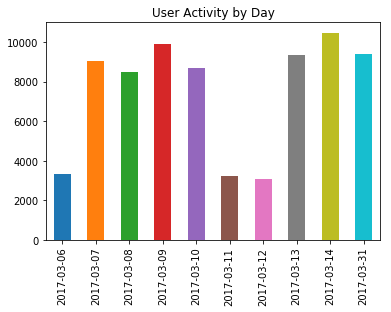

In [643]:
df.time.dt.date.value_counts(dropna=True).sort_index().plot(kind='bar', title='User Activity by Day')

It seems to have a day of week pattern.

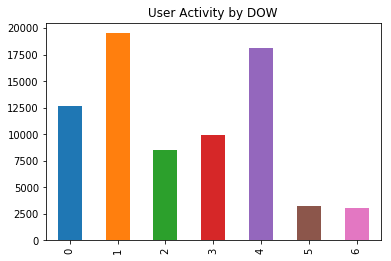

In [642]:
df.time.dt.dayofweek.value_counts(dropna=True).sort_index().plot(kind='bar',title='User Activity by DOW')

As expected, weekend(5-Sat, 6-Sun) has lower activity level. 

In [623]:
df.shape

(75091, 66)

#### use ip address to generate location info

In [685]:
# use GeoIP database to turn IP address to location information
# pip install maxminddb-geolite2
# https://github.com/rr2do2/maxminddb-geolite2
from geolite2 import geolite2

In [686]:
reader = geolite2.reader()

In [773]:
df['ip_loc']=df['ip']

In [ ]:
for i in range(len(df)):
    if pd.isna(df.ip_loc[i+1])==0: # some ip address is NaN
        if pd.isnull(reader.get(df.ip_loc[i+1]))==0:  # some ip does not have a match in database
            if pd.isnull(reader.get(df.ip_loc[i+1]).get('city'))==0: # if there's a city match in database, use city
                df.ip_loc[i+1]=reader.get(df.ip_loc[i+1])['city']['names']['en']
            elif pd.isnull(reader.get(df.ip_loc[i+1]).get('country'))==0: # if there's a country match in database, use country
                df.ip_loc[i+1]=reader.get(df.ip_loc[i+1])['country']['names']['en'] 
            else:
                df.ip_loc[i+1]=""
        else:
            df.ip_loc[i+1]=""

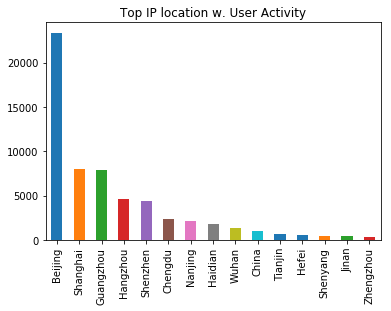

In [832]:
df.ip_loc.value_counts(dropna=True).nlargest(15).plot(kind='bar',title='Top IP location w. User Activity')
# when it's 'China', there's no city infor in database 
# Consider using up to Wuhan as seperate category and group the others 'rest' later

##### Look at pageStayTime distribution pattern, it only occurs for '_leave' events

In [847]:
df.pageStayTime.describe()

count    1.672000e+04
mean     6.681649e+03
std      5.343291e+04
min      3.300000e-02
25%      5.390750e+00
50%      2.057950e+01
75%      2.261860e+02
max      2.918014e+06
Name: pageStayTime, dtype: float64

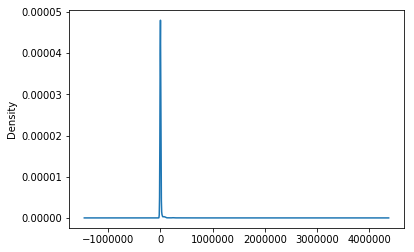

In [846]:
df.pageStayTime.plot.density()  # later treatment: floor with 0 and cap, and proabably log transformation

In [929]:
pd.pivot_table(df,index=['event'], values=['pageStayTime'],aggfunc=np.mean)

,pageStayTime
event,
$pageview,NaN
about_leave,5230.275391
btnClick,NaN
clickSubmit,NaN
click_send_cellphone,NaN
courses_leave,9430.613281
courses_play_leave,5449.115234
demo_leave,11990.604492
formSubmit,NaN


It seems that pageStayTime is only available for the _leave, or _close pages, not the instance pages (view, click, submit, code)

In [936]:
df.pagePosition.value_counts(dropna=False) # can keep as it is

NaN    58601
1      10679
2       4032
3        898
4        881
Name: pagePosition, dtype: int64

In [941]:
pd.pivot_table(df,index=['event','pagePosition'], values=['distinct_id'],aggfunc='count')

distinct_id
event              pagePosition             
about_leave        1                    1032
courses_leave      1                     906
courses_play_leave 1                     747
demo_leave         1                    3411
index_leave        1                    4583
                   2                    4032
                   3                     898
                   4                     881

Appearantly, pagePosition is only avaiable for '_leave' events, and only have value other then 1 for 'index_leave' event.

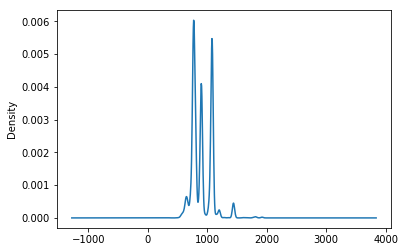

In [876]:
df.screen_height.plot.density() 

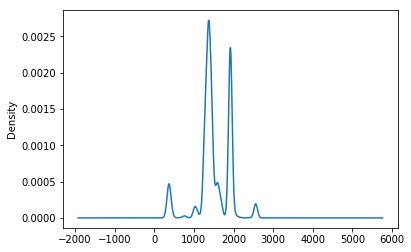

In [877]:
df.screen_width.plot.density() # might not be impactful, but can be used as a user profile numerical feature 

In [879]:
df.lib.value_counts(dropna=True)  # all same, no need to put in the model 

js    65672
Name: lib, dtype: int64

In [880]:
df.lib_version.value_counts(dropna=True)  # all same, no need to put in the model 

1.6.20    65672
Name: lib_version, dtype: int64

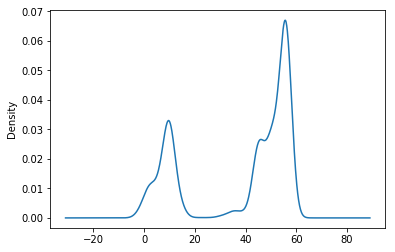

In [883]:
df.browser_version.plot.density() # might not be useful, but can be used as a user profile numerical feature 

In [867]:
df.type.value_counts(dropna=True)

profile_set_once     9419
track               65672
Name: type, dtype: int64

It seems like threre's always one record for each user about 'profile_set_once', the rest ones are all 'track'

In [ ]:
df[df['type']=='profile_set_once']

Observation: profile_set_once has 9419 records all happened on 2017-03-31  between 11:04 and 11:06: with most of the column values NA. That's also all the entries for 2017-03-31, which is further away from our date range. It seems like to be a one time system setting or error. Let's exclude those records for further analysis. 

some features might be only relevant at record level, not user level. Let's explore and select features needed for user level analysis and conversion prediction modeling later

In [1022]:
pd.pivot_table(df,index=['event','isMsg'], values=['distinct_id'],aggfunc='count') # keep

distinct_id
event      isMsg             
formSubmit false          230
           true           239

In [1025]:
pd.pivot_table(df,index=['event','requestBtn'], values=['distinct_id'],aggfunc='count')

distinct_id
event       requestBtn             
btnClick    1                   475
            10                   57
            2                  2042
            3                   192
            4                    94
            6                    85
            7                    21
clickSubmit 1                    86
            10                    5
            2                   369
            3                    29
            4                    14
            6                     9
            7                     1
formSubmit  1                   117
            10                   12
            2                   559
            3                    51
            4                    33
            6                    16
            7                     3

In [1012]:
df.jssdk_error.value_counts(dropna=False)

NaN                75033
cookieNotEnable       58
Name: jssdk_error, dtype: int64

In [1026]:
pd.pivot_table(df,index=['event','jssdk_error'], values=['distinct_id'],aggfunc='count') # can keep as a count

,,distinct_id
event,jssdk_error,
$pageview,cookieNotEnable,23
about_leave,cookieNotEnable,2
btnClick,cookieNotEnable,5
courses_leave,cookieNotEnable,1
demo_leave,cookieNotEnable,1
index_leave,cookieNotEnable,4


In [1042]:
pd.pivot_table(df,index=['event','page','name','requestBtn'], values=['distinct_id'],aggfunc='count')

distinct_id
event    page          name    requestBtn             
btnClick about         request 1                    15
                               10                    1
                               2                    52
         courses_index request 1                     6
                               10                    1
         demo          request 1                   196
                               10                    8
                               2                   260
         index         request 1                   198
                               10                   42
                               2                  1730
                               3                   192
                               4                    94

In [944]:
df.is_first_day.value_counts(dropna=False)

true     43230
false    22442
NaN       9419
Name: is_first_day, dtype: int64

In [945]:
df.is_first_time.value_counts(dropna=False)

false    56297
NaN       9419
true      9375
Name: is_first_time, dtype: int64

Can keep those as it is. is_first_day seem for all events for same user, is_first_time only for the first event.

In [948]:
df._nocache.count()

75091

Can't tell how to use '_nocache', let's leave this one out. 

In [957]:
df[df['type']=='track'].first_visit_time.count() # first_visit_time is for profile_set_once only, disregard

0

In [584]:
import matplotlib.pyplot as plt

In [595]:
df.event.value_counts(dropna=False)

$pageview                32620
btnClick                 13865
index_leave              10394
NaN                       9419
demo_leave                3411
about_leave               1032
courses_leave              906
formSubmit                 791
courses_play_leave         747
click_send_cellphone       600
verify_cellphone_code      563
clickSubmit                513
page_close                 230
Name: event, dtype: int64

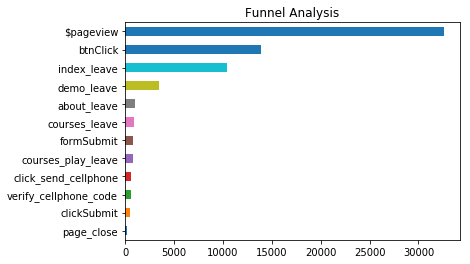

In [612]:
df.event.value_counts(dropna=True).sort_values(ascending=True).plot(kind='barh',title='Funnel Analysis')

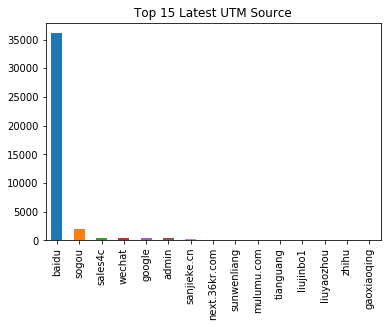

In [649]:
df.latest_utm_source.value_counts(dropna=True).nlargest(15).plot(kind='bar',title='Top 15 Latest UTM Source')

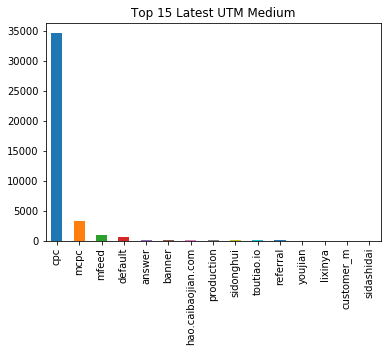

In [648]:
df.latest_utm_medium.value_counts(dropna=True).nlargest(15).plot(kind='bar',title='Top 15 Latest UTM Medium')

latest_referrer_hotst and _session_referrer_host are highly correlated, yet not exactly the same. Will determine later if we can use one of them of combine the two. _session_referrer_host has less NA.

Seems like there's a hierarchy: lastest_utm_campaign--> lastest_utm_content --> lastest_utm_term. Will determin which level to stop at when used in modeling. 

In [960]:
pd.pivot_table(df,index=['ch','_latest_ch'], values=['distinct_id'],aggfunc='count')

,,distinct_id
ch,_latest_ch,
36kr,36kr,2
36kr_cube,36kr_cube,1
chiyuan,chiyuan,2
demo,demo,448
ebiz_demo_doc,ebiz_demo_doc,5
edu_demo_doc,edu_demo_doc,2
itjuzi,itjuzi,6
lyz,lyz,2
pedaily,pedaily,3


exactly the same with _latest_ch, but the later one has fewer NA. keep the _latest_ch

In [866]:
df.distinct_id.unique().shape, df.shape

((11756,), (75091, 67))

In [1045]:
# Remove the rows with no information
df_u=df[df['type']!='profile_set_once']

In [1046]:
df_u.shape

(65672, 67)

### <font color='green'> 3. Data Transformation to User-level attributes: </font> 

### 1. User profile attributes:

In [1083]:
df_t=df_u[['distinct_id','os','model','os_version','screen_height','screen_width','event', 'browser','browser_version','ip','ip_loc']].groupby(['distinct_id']).nunique()

In [1084]:
df_t.shape

(11708, 11)

In [1085]:
df_t.sum()

distinct_id        11708
os                 11732
model              11732
os_version         11744
screen_height      11944
screen_width       11944
event              28272
browser            11744
browser_version    11787
ip                 13034
ip_loc             11950
dtype: int64

It's almost a 1 to 1 ratio. the distinct_id with multiple os, model, ips could be potential heavy users, so we cannot disregard. Here we select the most frequent value for their user profile feature, and created a new feature called 'multi_device_flag'.

In [1086]:
df_t[df_t['os']>1]

,distinct_id,os,model,os_version,screen_height,screen_width,event,browser,browser_version,ip,ip_loc
distinct_id,,,,,,,,,,,
07bb59598164abb4517e52e00f56e901e3c124a9,1,2,2,2,3,3,1,3,4,3,2
08ba9b365da9b395ab2a03ed1a76b97e01716a39,1,3,3,3,6,6,3,2,2,1,1
0f3ab2be43d5fe660e46c2ce6a62ce7aec4865cd,1,2,2,2,2,2,1,2,2,1,1
19db3f7f99eb0f14e5ea5730fe3a936996941269,1,2,2,3,3,3,6,1,2,6,4
203d5340264bc657e4de1c529040dfb0dfafdc4a,1,2,2,3,4,4,5,3,4,13,4
2588148499013b29b2c26f207dd6b3780d0bf391,1,2,2,2,2,2,1,2,2,1,1
26cc7e35085fb444075e01f4144a34593b847e96,1,2,2,2,2,2,1,2,2,1,1
3944501ebb4b71766c0dedca37f2f38727e65059,1,2,2,3,1,1,4,1,3,2,2
8c40e0fa27396c94957285f7f8780d64c0e10f85,1,3,3,3,3,3,4,2,3,1,1


In [1109]:
p=list(df_t[df_t['os']>1].index) # potential heavy user

use mode for user profile features and referrer, utm ad campaign related fatures, and label user with multiple devices later


In [1204]:
# use mode for user profile features and referrer, utm ad campaign related fatures, and label user with multiple devices later

df_t=df_u[['distinct_id','os','model','os_version','screen_height','screen_width','browser','browser_version','ip','ip_loc','first_browser_language','first_referrer_host','latest_referrer_host','latest_utm_source','latest_utm_medium','latest_utm_campaign','latest_utm_content','latest_utm_term','_latest_ch','utm_source','utm_medium','utm_campaign','utm_content','utm_term']].groupby(['distinct_id']).agg(lambda x:x.value_counts(dropna=False).index[0])




In [1208]:
ur.reset_index(inplace=True)

In [1209]:
# added multi_device flage=True, if the user appeared on the prior multi-device list
ur['multi_device']=ur.distinct_id.isin(p)

### 2. Event-base features:

2.1 Collapse features to meaningful bigger buckets before generating dummy variables: 

In [1219]:
k=df_u.name.isin(['request','demo','document','blog','viedo','about','logo','mail','b-round','product'])

In [ ]:
df_u['name']=np.where(k,df_u['name'],'other')

2.2 Generate Dummy features for all categorical features: in a form of if this value exist (1), or not (0).

In [1233]:
col_category = ['event', 'page', 'pagePosition','name','requestBtn','project_name','isSuccess','isMsg','jssdk_error']

In [1234]:
df_dummies = pd.get_dummies(df_u[col_category], columns=col_category,dummy_na=True)

In [1244]:
df_dummies.drop(columns=['event_nan', 'name_nan'],inplace=True)

In [1245]:
df_dummies.shape

(65672, 48)

In [1246]:
df_u = df_u.join(df_dummies)

In [1247]:
df_u.shape

(65672, 115)

2.3 Sum the boolean features created as count of the action happening:

In [1256]:
dm=list(df_dummies)

list

In [1259]:
l=['distinct_id']+dm

In [1248]:
df_c6=df_u.copy()

In [1265]:
t2=df_u[l].groupby(['distinct_id']).sum()

In [1267]:
ur.shape

(11708, 25)

In [1274]:
ur=ur.join(t2, on='distinct_id')

In [1278]:
# is first time: max, is first day: max , if one of the instances of the user is true, then true
ft=df_u[['distinct_id','is_first_day','is_first_time']].groupby(['distinct_id']).max()

In [1280]:
ur=ur.join(ft, on='distinct_id')

### 3. Page specific features: 

These feature only occurs with specific pages/events, ex.:
<br>
pageStayTime only exist for '_leave' events
<br>
value of PagePosition only varies when event=index_leave

So cannot simply aggregate them at a user level. Hence created sepecific features for the specific events with an average for these feature values.

In [1301]:
pt=df_u['pageStayTime'].groupby([df_u['distinct_id'], df_u['event']]).mean().unstack()

In [1304]:
pt.drop(columns=['$pageview','btnClick','clickSubmit','click_send_cellphone', 'formSubmit','page_close','verify_cellphone_code'],inplace=True)

In [1305]:
list(pt)

['about_leave',
 'courses_leave',
 'courses_play_leave',
 'demo_leave',
 'index_leave']

In [1307]:
pt.rename(columns={'about_leave':'pageStayTime_about','index_leave':"pageStayTime_index",'courses_leave':'pageStayTime_courses','courses_play_leave':'pageStayTime_coursesPlay','demo_leave':'pageStayTime_demo'},inplace=True)

In [1308]:
pt.shape

(11708, 5)

In [1309]:
ur=ur.join(pt, on='distinct_id')

In [1310]:
ur.shape

(11708, 80)

In [1324]:
pd.pivot_table(df,index=['event','pagePosition'], values=['distinct_id'],aggfunc='count')

distinct_id
event              pagePosition             
about_leave        1                    1032
courses_leave      1                     906
courses_play_leave 1                     747
demo_leave         1                    3411
index_leave        1                    4583
                   2                    4032
                   3                     898
                   4                     881

Seems that pagePosition only matters for index_leave page:

In [1316]:
df_u['pagePositionN'] = df_u['pagePosition'].astype('float32')

In [1320]:
pp=df_u['pagePositionN'].groupby([df_u['distinct_id'], df_u['event']]).mean().unstack()

In [1322]:
list(pp)

['$pageview',
 'about_leave',
 'btnClick',
 'clickSubmit',
 'click_send_cellphone',
 'courses_leave',
 'courses_play_leave',
 'demo_leave',
 'formSubmit',
 'index_leave',
 'page_close',
 'verify_cellphone_code']

In [1325]:
pp=pp.filter(['index_leave'])

In [1327]:
pp.rename(columns={'index_leave':'pagePosition_index'},inplace=True)

In [1329]:
ur=ur.join(pp, on='distinct_id')

### 4. Time related features:

Created several features related to timestamp: 
1. Total time span for this user: time difference between their last activity to their first activity. 
2. Day of Week
3. Hour of Day 

In [1383]:
ts=df_u[['time']].groupby(df_u['distinct_id']).agg({"time":[min, max]})

In [1389]:
ts.columns = ts.columns.droplevel(level=0)

In [1392]:
ts['total_time']=(ts['max']-ts['min']).dt.seconds

In [1394]:
ts['hour']=ts['min'].dt.hour

In [1395]:
ts['DayofWeek']=ts['max'].dt.dayofweek

In [1401]:
ur=ur.join(ts, on='distinct_id')

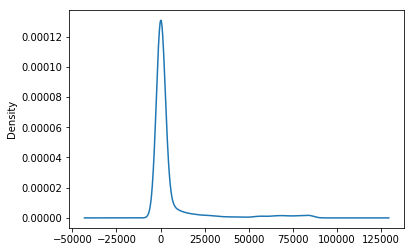

In [1374]:
ts.Total_time.plot.density()

#### data all ready, start processing

### <font color='green'> 4. Second Round User-level Feature Pre-processing & EDA: </font> 

Because of the nature of the data, the EDA & feature pre-processing has been done not in the order of numerical vs. categorical, but user profile features -> referrer & utm features -> event/page level features -> time features

### User Profile Features: 
Collapse levels when necessary: look at top frequency levels, and levels with interesting user behaviors

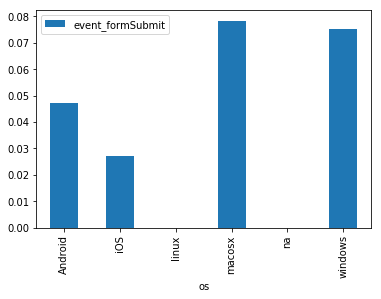

In [29]:
ur[['os', 'event_formSubmit']].groupby(['os']).mean().plot.bar() # keep the feature as it is 

In [53]:
k=ur.os.isin(['windows','macosx','iOS','Android'])
ur['os']=np.where(k,ur['os'],'other')

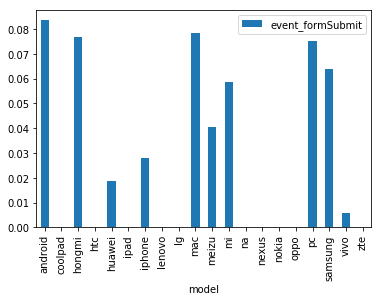

In [31]:
ur[['model', 'event_formSubmit']].groupby(['model']).mean().plot.bar() # let's collaps into bigger groups

In [48]:
k=ur.model.isin(['pc','mac','android','huawei','vivo','mi','hongmi','samsung','meizu','iphone'])

In [49]:
ur['model']=np.where(k,ur['model'],'other')

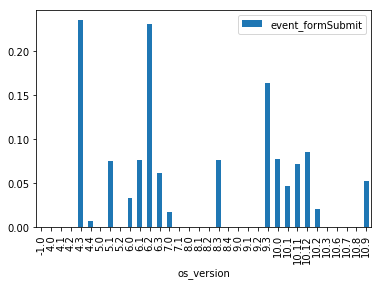

In [19]:
ur[['os_version', 'event_formSubmit']].groupby(['os_version']).mean().plot.bar()

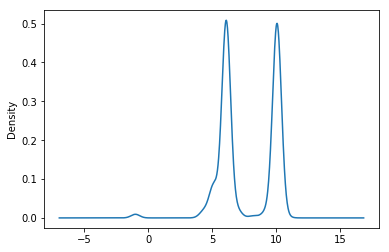

In [22]:
ur.os_version.plot.density()

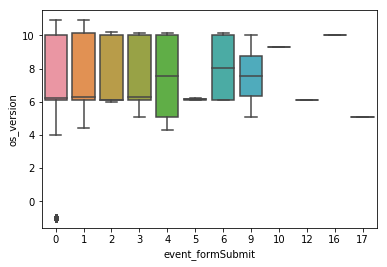

In [24]:
import seaborn
seaborn.boxplot(ur['event_formSubmit'],ur['os_version'])

### Define Response Variable Y as formSubmit
Based on the first round of EDA, formSubmit seems to be a reasonable classification target, since it has a bigger 'yes' population. Also, it reflects purely on user intension, not impacted by system errors, cell phone outage, etc. So it's better for predictive modeling.

In [50]:
ur['y']=np.where(ur['event_formSubmit']==0,0,1)

In [27]:
ur.y.value_counts()

0    11211
1      497
Name: y, dtype: int64

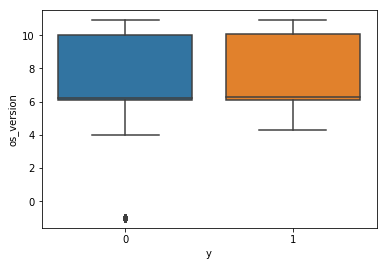

In [31]:
seaborn.boxplot(ur['y'],ur['os_version']) # dont't see a correlation, can leave this variable out or keep as numerical

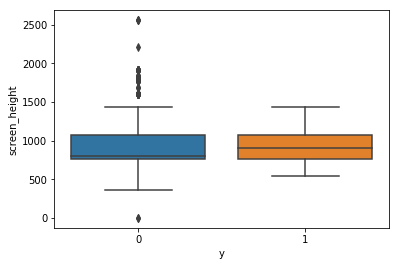

In [29]:
seaborn.boxplot(ur['y'],ur['screen_height'])

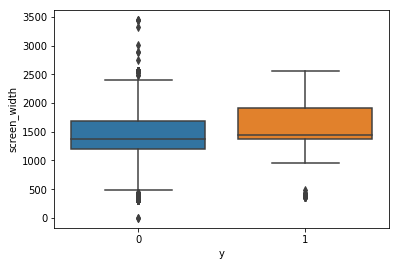

In [30]:
seaborn.boxplot(ur['y'],ur['screen_width'])

 Nonlinearity through binning and plotting subscription rate across different bins, checking if any treatment is necessary.

In [418]:
b=ur['y'].groupby(pd.cut(ur['screen_width'],10)).value_counts()
c=b.groupby(level=[0]).apply(lambda x: x / float(x.sum()))

In [419]:
c

screen_width      y
(-3.44, 344.0]    0    1.000000
(344.0, 688.0]    0    0.982540
                  1    0.017460
(688.0, 1032.0]   0    0.996974
                  1    0.003026
(1032.0, 1376.0]  0    0.947956
                  1    0.052044
(1376.0, 1720.0]  0    0.945471
                  1    0.054529
(1720.0, 2064.0]  0    0.953108
                  1    0.046892
(2064.0, 2408.0]  0    0.900000
                  1    0.100000
(2408.0, 2752.0]  0    0.926829
                  1    0.073171
(2752.0, 3096.0]  0    1.000000
(3096.0, 3440.0]  0    1.000000
Name: y, dtype: float64

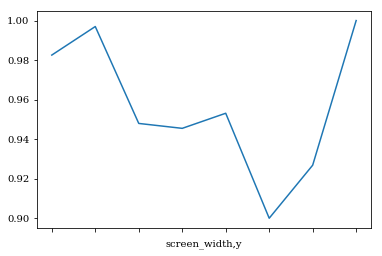

In [421]:
c[1::2].plot(rot=45) 

We can see some non-linearity in screen_width. We can use binning to address that later if we want to improve the performance of Logistic Regression model further. However, since we're using tree based models later, let's keep the feature as it is for now. 

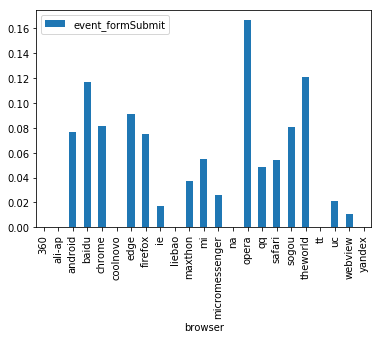

In [34]:
ur[['browser', 'event_formSubmit']].groupby(['browser']).mean().plot.bar() 

In [51]:
k=ur.browser.isin(['chrome','safari','qq','baidu','edge','firefox','sougou','opera','micromessenger','uc'])
ur['browser']=np.where(k,ur['browser'],'other')

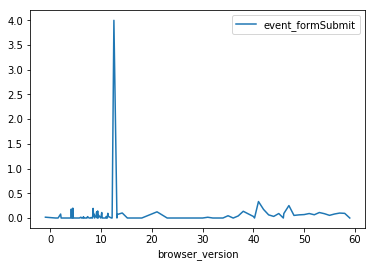

In [39]:
ur[['browser_version', 'event_formSubmit']].groupby(['browser_version']).mean().plot.line() # not linear, but let's see if tree models perform better on this one

In [62]:
ur.first_browser_language.value_counts(dropna=False)

NaN    11708
Name: first_browser_language, dtype: int64

In [63]:
ur.drop(columns=['first_browser_language'],inplace=True) # no extra information to offer 

In [60]:
k=ur.ip_loc.isin(['Beijing','Guangzhou','Shanghai','Hangzhou','Shenzhen','Chengdu','Nanjing','Wuhan'])
ur['ip_loc']=np.where(k,ur['ip_loc'],'other')

### Referrer and utm attributes:
At a user level, the latest_utm_source/medium/campiagn/content/term and _latest_ch features seem to offer the most information. So selected these features and collapse to fewer meaningful levels.

In [84]:
k=ur.latest_referrer_host.isin(['www.baidu.com','m.baidu.com','www.sogou.com','36kr.com','wap.sogou.com','m.sogou.com','www.google.com.hk','link.zhihu.com','www.google.com','image.baidu.com'])
ur['latest_referrer_host']=np.where(k,ur['latest_referrer_host'],'other')

In [85]:
k=ur.latest_utm_source.isin(['baidu','sogou','google','wechat'])
ur['latest_utm_source']=np.where(k,ur['latest_utm_source'],'other')

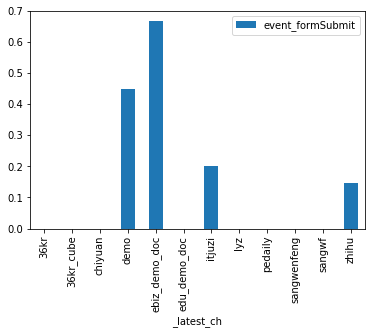

In [86]:
ur[['_latest_ch', 'event_formSubmit']].groupby(['_latest_ch']).mean().plot.bar() 

In [88]:
k=ur._latest_ch.isin(['demo','zhihu'])
ur['_latest_ch']=np.where(k,ur['_latest_ch'],'other')

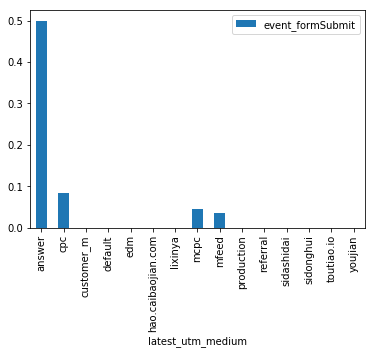

In [89]:
ur[['latest_utm_medium', 'event_formSubmit']].groupby(['latest_utm_medium']).mean().plot.bar() 

In [91]:
k=ur.latest_utm_medium.isin(['cpc','mcpc','mfeed'])
ur['latest_utm_medium']=np.where(k,ur['latest_utm_medium'],'other')

In [97]:
k=ur.latest_utm_campaign.isin(['通用词','品牌词','S-通用词','首页','神策-移动推广','G-通用词'])
ur['latest_utm_campaign']=np.where(k,ur['latest_utm_campaign'],'other')

In [103]:
test2=test.copy()

In [105]:
k=ur.latest_utm_content.isin(['通用-用户画像','品牌-神策','通用-数据分析','通用词-三图','通用词-M'])
ur['latest_utm_content']=np.where(k,ur['latest_utm_content'],'other')

In [106]:
k=ur.latest_utm_term.isin(['用户画像','神策','首页-通用词-三图-图1','数据分析'])
ur['latest_utm_term']=np.where(k,ur['latest_utm_term'],'other')

In [108]:
ur.drop(columns=['ip','first_referrer_host','utm_source','utm_medium','utm_campaign','utm_content', 'utm_term'],inplace=True) # no extra information to offer 

### Event related features
Some features happened after formSubmit, or have a direct (almost 1-1) relationship with formSubmit, hence should not be put into the model

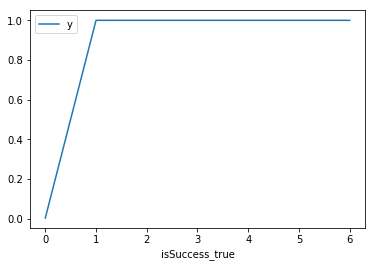

In [112]:
ur[['isSuccess_true', 'y']].groupby(['isSuccess_true']).mean().plot()  # features that happened after formSubmit, 
# hence should not be put into the model

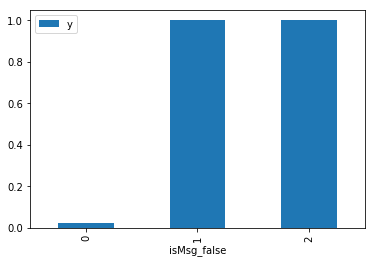

In [116]:
ur[['isMsg_false', 'y']].groupby(['isMsg_false']).mean().plot.bar()

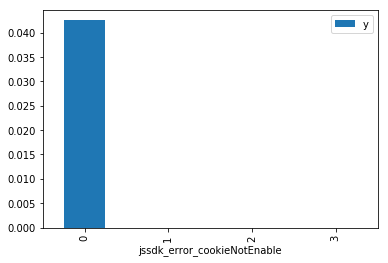

In [117]:
ur[['jssdk_error_cookieNotEnable', 'y']].groupby(['jssdk_error_cookieNotEnable']).mean().plot.bar()

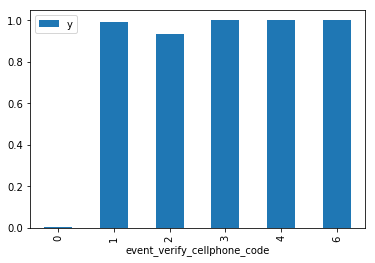

In [118]:
ur[['event_verify_cellphone_code', 'y']].groupby(['event_verify_cellphone_code']).mean().plot.bar()

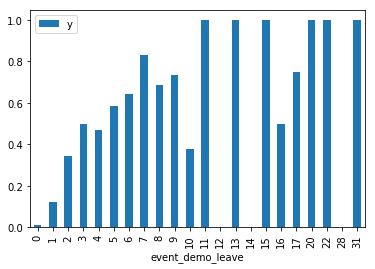

In [134]:
ur[['event_demo_leave', 'y']].groupby(['event_demo_leave']).mean().plot.bar()

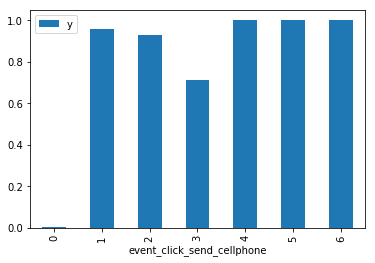

In [130]:
ur[['event_click_send_cellphone', 'y']].groupby(['event_click_send_cellphone']).mean().plot.bar()

In [135]:
# drop the columns that happend post formSubmit
ur.drop(columns=['event_clickSubmit', 'event_click_send_cellphone', 'event_demo_leave','event_verify_cellphone_code', 'page_nan','requestBtn_nan','project_name_nan', 'isSuccess_false','isSuccess_true', 'isSuccess_nan', 'isMsg_false', 'isMsg_true',
'isMsg_nan', 'jssdk_error_cookieNotEnable', 'jssdk_error_nan'],inplace=True) 

In [136]:
ur.shape

(11708, 64)

### NA treatment
Since we finished the first round of EDA. Here, the NA values left have meanings: the specific event/action did not happen. We impute 0 for the numerical variable pageStayTime, and create a seperate level for categorical variable pagePosition.

In [189]:
n=ur.isna().sum()

In [190]:
n[n>0]

pageStayTime_about          10996
pageStayTime_courses        11016
pageStayTime_coursesPlay    11338
pageStayTime_demo           10272
pageStayTime_index           4762
pagePosition_index           4762
dtype: int64

In [188]:
ur.pageStayTime_about.describe()

count     11708.000000
mean        405.581704
std       13332.571628
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      951302.200000
Name: pageStayTime_about, dtype: float64

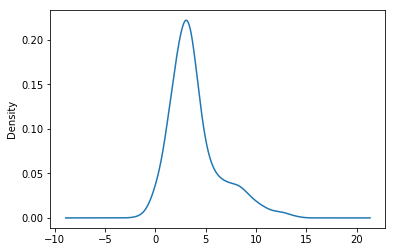

In [144]:
np.log(ur.pageStayTime_about).plot.density()

In [161]:
ur['pageStayTime_about'] = ur['pageStayTime_about'].fillna(0)

In [183]:
ur['pageStayTime_courses'] = ur['pageStayTime_courses'].fillna(0)
ur['pageStayTime_coursesPlay'] = ur['pageStayTime_coursesPlay'].fillna(0)
ur['pageStayTime_demo'] = ur['pageStayTime_demo'].fillna(0)
ur['pageStayTime_index'] = ur['pageStayTime_index'].fillna(0)

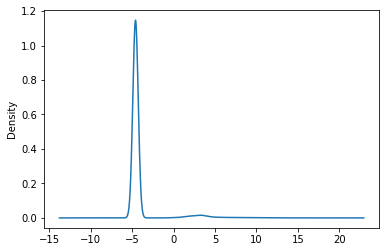

In [169]:
np.log(ur.pageStayTime_about+0.01).plot.density()  

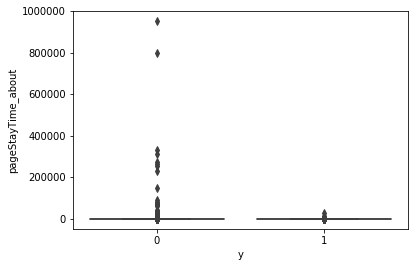

In [171]:
seaborn.boxplot(ur['y'],ur['pageStayTime_about'])

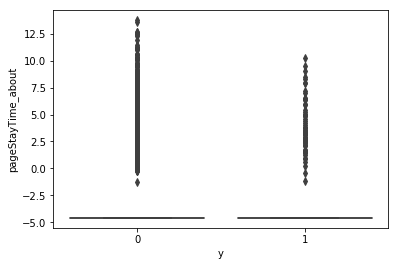

In [173]:
seaborn.boxplot(ur['y'],np.log(ur['pageStayTime_about']+0.01))

log transform would help, but it would hurt the classficiation effort as well
since we're trying tree models later, let's keep the features as original as possible, without log transformation

In [210]:
ur['pagePosition_index'] = ur['pagePosition_index'].fillna(0)

In [208]:
ur['pagePosition_index'] = ur['pagePosition_index'].astype('int32')

In [212]:
ur['pagePosition_index'] = ur['pagePosition_index'].astype('category')

In [213]:
ur.pagePosition_index.value_counts(dropna=False)

0    4762
1    2852
2    2844
3     709
4     541
Name: pagePosition_index, dtype: int64

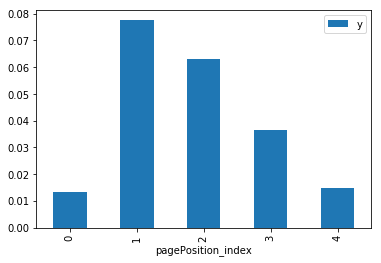

In [214]:
ur[['pagePosition_index', 'y']].groupby(['pagePosition_index']).mean().plot.bar()

In [216]:
ur_2=ur.copy()

### Time Related Features

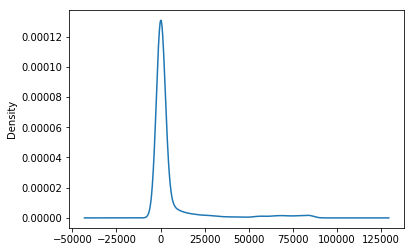

In [219]:
ur.total_time.plot.density()

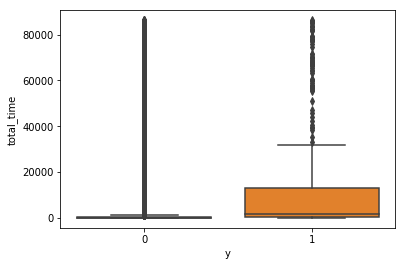

In [220]:
seaborn.boxplot(ur['y'],ur['total_time'])

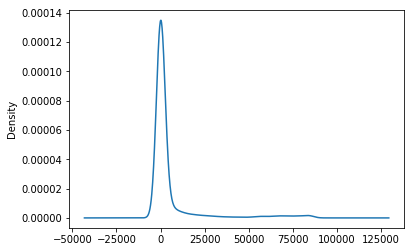

In [221]:
ur[ur['y']==0].total_time.plot.density()

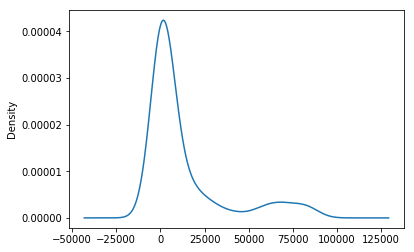

In [222]:
ur[ur['y']==1].total_time.plot.density()

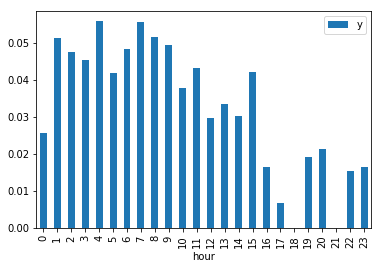

In [223]:
ur[['hour', 'y']].groupby(['hour']).mean().plot.bar()

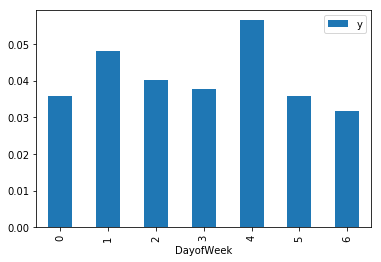

In [224]:
ur[['DayofWeek', 'y']].groupby(['DayofWeek']).mean().plot.bar()

#### Drop some other features that's formSubmit or demo related, or not used for modeling

In [229]:
ur.drop(columns=['distinct_id','event_formSubmit','min', 'max'],inplace=True)

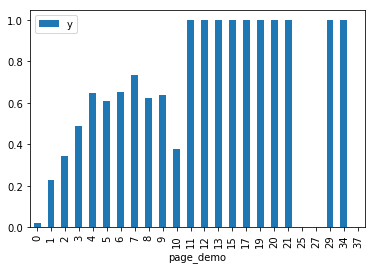

In [317]:
ur[['page_demo', 'y']].groupby(['page_demo']).mean().plot.bar()

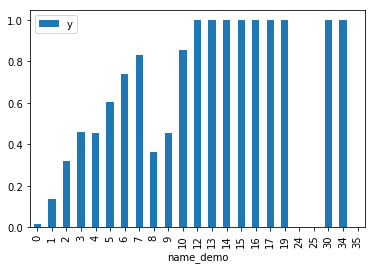

In [319]:
ur[['name_demo', 'y']].groupby(['name_demo']).mean().plot.bar()

In [375]:
# some other features needed to be dropped because it's directly related to formSubmit or Demo
ur.drop(columns=['requestBtn_2','requestBtn_1','requestBtn_3','requestBtn_6','requestBtn_4','requestBtn_10','requestBtn_7',
'name_request','name_other','name_demo','name_document','page_demo','_latest_ch_demo','pageStayTime_demo'],inplace=True)

#### Creat Dummies for categorical features 

In [230]:
cat_features = ['os','model','browser','ip_loc','latest_referrer_host','latest_utm_source','latest_utm_medium','latest_utm_campaign','latest_utm_content','latest_utm_term','_latest_ch']



In [231]:
ur= pd.get_dummies(ur, columns=cat_features)

In [329]:
ur.to_csv('model_data.csv', index=False, encoding='utf-8')

In [376]:
df=ur.copy()

### <font color='green'> 5. Modeling & Result Interpretation </font> 

### Model Preparation
### Define Features and Target

In [377]:
df.columns.values

array(['os_version', 'screen_height', 'screen_width', 'browser_version',
       'multi_device', 'event_$pageview', 'event_about_leave',
       'event_btnClick', 'event_courses_leave',
       'event_courses_play_leave', 'event_index_leave',
       'event_page_close', 'page_about', 'page_courses_index',
       'page_index', 'name_about', 'name_b-round', 'name_blog',
       'name_logo', 'name_mail', 'name_product', 'name_viedo',
       'project_name_default', 'project_name_hunter',
       'project_name_production', 'is_first_day', 'is_first_time',
       'pageStayTime_about', 'pageStayTime_courses',
       'pageStayTime_coursesPlay', 'pageStayTime_index',
       'pagePosition_index', 'total_time', 'hour', 'DayofWeek', 'y',
       'os_Android', 'os_iOS', 'os_macosx', 'os_other', 'os_windows',
       'model_android', 'model_hongmi', 'model_huawei', 'model_iphone',
       'model_mac', 'model_meizu', 'model_mi', 'model_other', 'model_pc',
       'model_samsung', 'model_vivo', 'browser_baidu',

In [378]:
selected_features = list(df.columns.values)
target = 'y'
selected_features.remove(target)

In [380]:
X = df[selected_features].values
y = df[target].values

In [381]:
X.shape

(11708, 110)

In [382]:
y

array([1, 0, 0, ..., 0, 0, 0])

#### Let's Train-test split the data

In [383]:
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

For Modeling, let's start with Logitic Regression for better interpretation. After we have a decent understanding of the impact of different features, we can explore other machine learning models to test for the best performing classifiers.

### Build Logistic Regression Model

#### Logistic Regression model using sklearn, with standardization, regularization, and P-value testing
Since we have both numerical and categorical features here, with different scales, let's standardize data before modeling and regularization. 

In [384]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [ ]:
SX=scaler.fit_transform(X,y)

In [386]:
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
SX_train, SX_test, y_train, y_test = train_test_split(SX, y, test_size=0.3, random_state=0)

In [387]:
SX_train.shape

(8195, 110)

In [388]:
SX[:,1]

array([-1.06521433,  0.15875412, -0.78680091, ..., -0.5346529 ,
        1.10430916, -0.5346529 ])

In [430]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize model by providing parameters
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(C=1,penalty='l2')

# Fit a model by providing X and y from training set
clf.fit(SX_train, y_train)

# Make prediction on the training data
y_train_pred = clf.predict(SX_train)
p_train_pred = clf.predict_proba(SX_train)[:,1]

# Make predictions on test data
y_test_pred = clf.predict(SX_test)
p_test_pred = clf.predict_proba(SX_test)[:,1]

### Calculate the metric scores for the model

In [431]:
 # Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [432]:
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [433]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

              train      test
metrics                      
AUC        0.938053  0.873105
Accuracy   0.965589  0.964133
Precision  0.687861  0.650000
Recall     0.342939  0.346667
f1-score   0.457692  0.452174


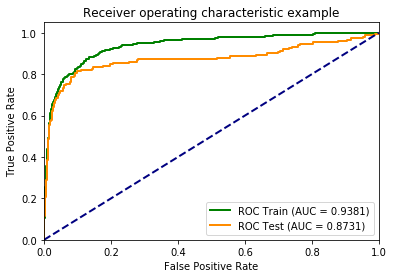

In [434]:
# print model results
get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

##### Check P-value to see if any feature needs to be excluded due to non-significance

In [ ]:
from sklearn import feature_selection
f=feature_selection.f_regression(X_train, y_train, center=True)

In [436]:
from collections import OrderedDict
score = {'Feature': selected_features, 'F Score': f[0], 'P-Value': f[1]}
s = pd.DataFrame( OrderedDict(score))
s['significant']=s['P-Value']<0.1       
s

,Feature,F Score,P-Value,significant
0,os_version,1.420619,2.333361e-01,False
1,screen_height,2.781188,9.541559e-02,True
2,screen_width,25.679543,4.118874e-07,True
3,browser_version,32.508296,1.228039e-08,True
4,multi_device,0.219212,6.396536e-01,False
5,event_$pageview,432.788927,1.030718e-93,True
6,event_about_leave,24.335608,8.252233e-07,True
7,event_btnClick,1107.374802,7.309451e-228,True
8,event_courses_leave,18.207216,2.003561e-05,True
9,event_courses_play_leave,13.664759,2.199432e-04,True


From the results we can tell, more than half of the fearures are significant.

### Understanding the Estimated Coefficients

In [437]:
df_coeffs = pd.DataFrame(list(zip(selected_features, clf.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs

,feature,coeff
7,event_btnClick,1.588220
86,latest_utm_medium_cpc,0.624958
14,page_index,0.558734
83,latest_utm_source_other,0.535026
25,is_first_day,0.464347
91,latest_utm_campaign_S-通用词,0.389467
94,latest_utm_campaign_神策-移动推广,0.248899
52,browser_chrome,0.184059
5,event_$pageview,0.180011
100,latest_utm_content_通用-用户画像,0.176811


In [438]:
mpl.rc('font', family='DejaVu Sans')

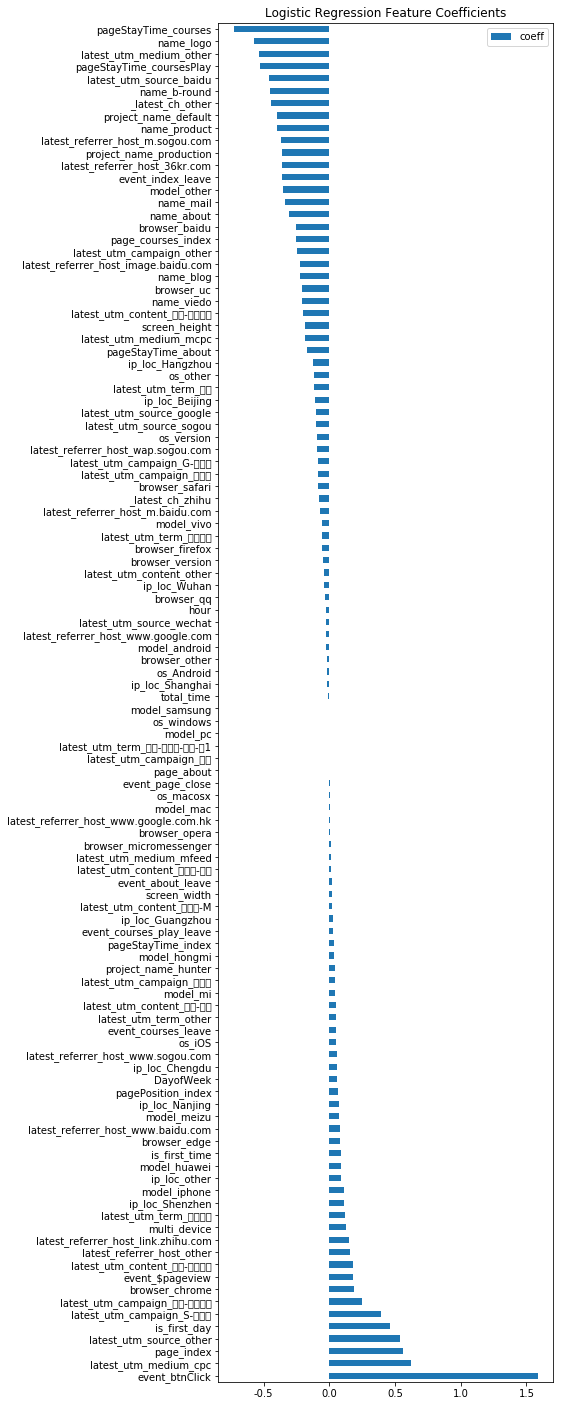

In [439]:
ax = df_coeffs.plot.barh()
t = np.arange(X.shape[1])
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.gcf().set_size_inches(6, 25)
plt.title('Logistic Regression Feature Coefficients')
plt.show()

From the coefficients, we have seen big negative correlations from:
<br>
latest_utm_source_baidu; pageStayTime_coursesPlay; name_logo; pageStayTime_courses; 
<br>

Big positive correlations from: 
<br>
event_btnClick, latest_utm_medium_cpc, page_index,latest_utm_campaign_S-通用词,latest_utm_campaign_神策-移动推广	, browser_chrome, event_$pageview

In [440]:
# define function to perform train, test, and get model performance
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)


### Random Forest

              train      test
metrics                      
AUC        0.986167  0.961929
Accuracy   0.964002  0.959579
Precision  0.981481  0.785714
Recall     0.152738  0.073333
f1-score   0.264339  0.134146


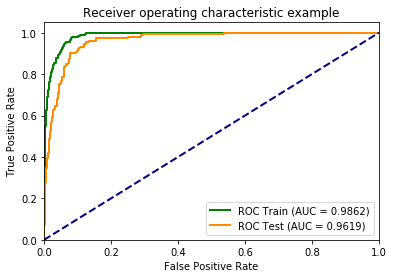

In [441]:
from sklearn.ensemble import RandomForestClassifier

# Choose some parameter combinations to try
parameters = {'n_estimators': 100,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 50,
              'min_samples_split': 2,
              'min_samples_leaf': 10,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

In [442]:
df_coeffs = pd.DataFrame(list(zip(selected_features, clf.feature_importances_))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'importance']
df_coeffs[0:30]

,feature,importance
7,event_btnClick,0.152442
5,event_$pageview,0.115419
14,page_index,0.104508
30,pageStayTime_index,0.092326
108,_latest_ch_other,0.079894
32,total_time,0.077079
10,event_index_leave,0.035569
20,name_product,0.020617
3,browser_version,0.019801
33,hour,0.017897


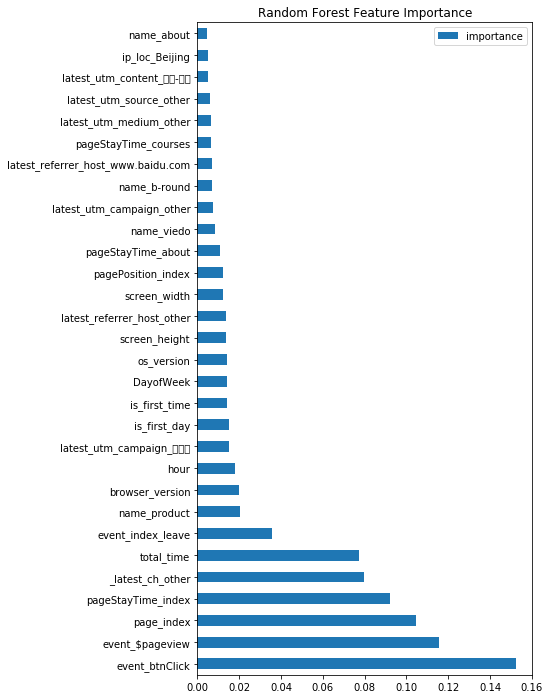

In [443]:
ax = df_coeffs[0:30].plot.barh()
ax.set_yticklabels(df_coeffs['feature'])
plt.gcf().set_size_inches(6, 12)
plt.title('Random Forest Feature Importance')
plt.show()

The performance of Random Forest is as good as expected. The model runs very quickly as well. 

The most importance features are: 
event_btnClick, event_$pageview, page_index, pageStayTime_index, total_time, browser_version, hour


### Gradient Boosting Trees

              train      test
metrics                      
AUC        0.999986  0.961493
Accuracy   0.998292  0.966695
Precision  1.000000  0.657143
Recall     0.959654  0.460000
f1-score   0.979412  0.541176


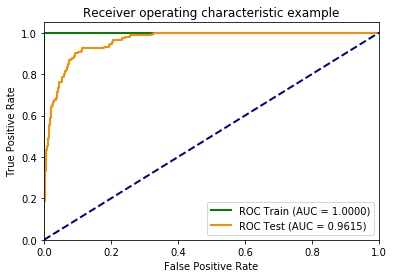

In [444]:
from sklearn.ensemble import GradientBoostingClassifier

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.2,
    'random_state': 42
}

clf = GradientBoostingClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

In [445]:
df_coeffs = pd.DataFrame(list(zip(selected_features, clf.feature_importances_))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'importance']
df_coeffs[0:30]

,feature,importance
30,pageStayTime_index,0.160385
32,total_time,0.110134
7,event_btnClick,0.070495
14,page_index,0.063124
5,event_$pageview,0.051941
33,hour,0.044145
3,browser_version,0.036219
34,DayofWeek,0.032226
28,pageStayTime_courses,0.027329
0,os_version,0.019747


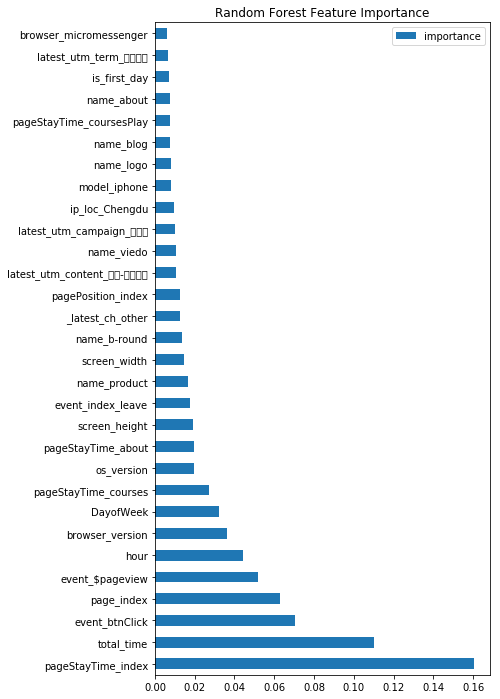

In [446]:
ax = df_coeffs[0:30].plot.barh()
ax.set_yticklabels(df_coeffs['feature'])
plt.gcf().set_size_inches(6, 12)
plt.title('Random Forest Feature Importance')
plt.show()

Gradient Boosting Trees seem to perform close to random forest. 
<br>
The most important features are: 
<br>
pageStayTime_index, total_time, event_btnClick, page_index, event_$pageview, hour, browser_version, DayofWeek

Performance Summary: 
<br>
Logistic Regression performance not as good as tree based models, but likly due to the heavy number of non-linear features, and we go light on feature transformation, binning and capping on purpose, to keep as much information as possible for tree models.
<br>
Gradient Boosting Trees and Random Forest seem to be the best classifier in this case. The performance and feature importance ranking are pretty similar among the two as well. 